article: 8000
topic count: [4826, 4477, 5553, 4686, 3945, 4610]
next year: 1982
previous year: 1981
article: 13197
topic count: [3253, 3119, 3747, 3163, 2861, 3180]
next year: 1983
previous year: 1982
article: 21197
topic count: [5335, 5246, 6118, 5224, 5012, 5256]
next year: 1984
previous year: 1983
article: 29197
topic count: [4928, 4798, 5803, 4745, 4474, 5063]
next year: 1985
previous year: 1984
article: 37197
topic count: [4701, 4721, 5487, 4595, 4221, 5083]
next year: 1986
previous year: 1985
article: 45197
topic count: [4830, 4943, 6052, 4689, 4975, 5274]
next year: 1987
previous year: 1986
article: 53197
topic count: [4930, 4834, 6446, 4736, 5320, 5319]
next year: 1988
previous year: 1987
article: 61187
topic count: [4524, 4397, 5783, 4130, 4540, 4973]
next year: 1989
previous year: 1988
article: 69186
topic count: [4884, 4702, 6451, 4589, 5351, 5275]
next year: 1990
previous year: 1989
article: 77186
topic count: [4651, 4451, 5559, 4141, 4198, 4710]
next year: 1991
previous ye

No handles with labels found to put in legend.


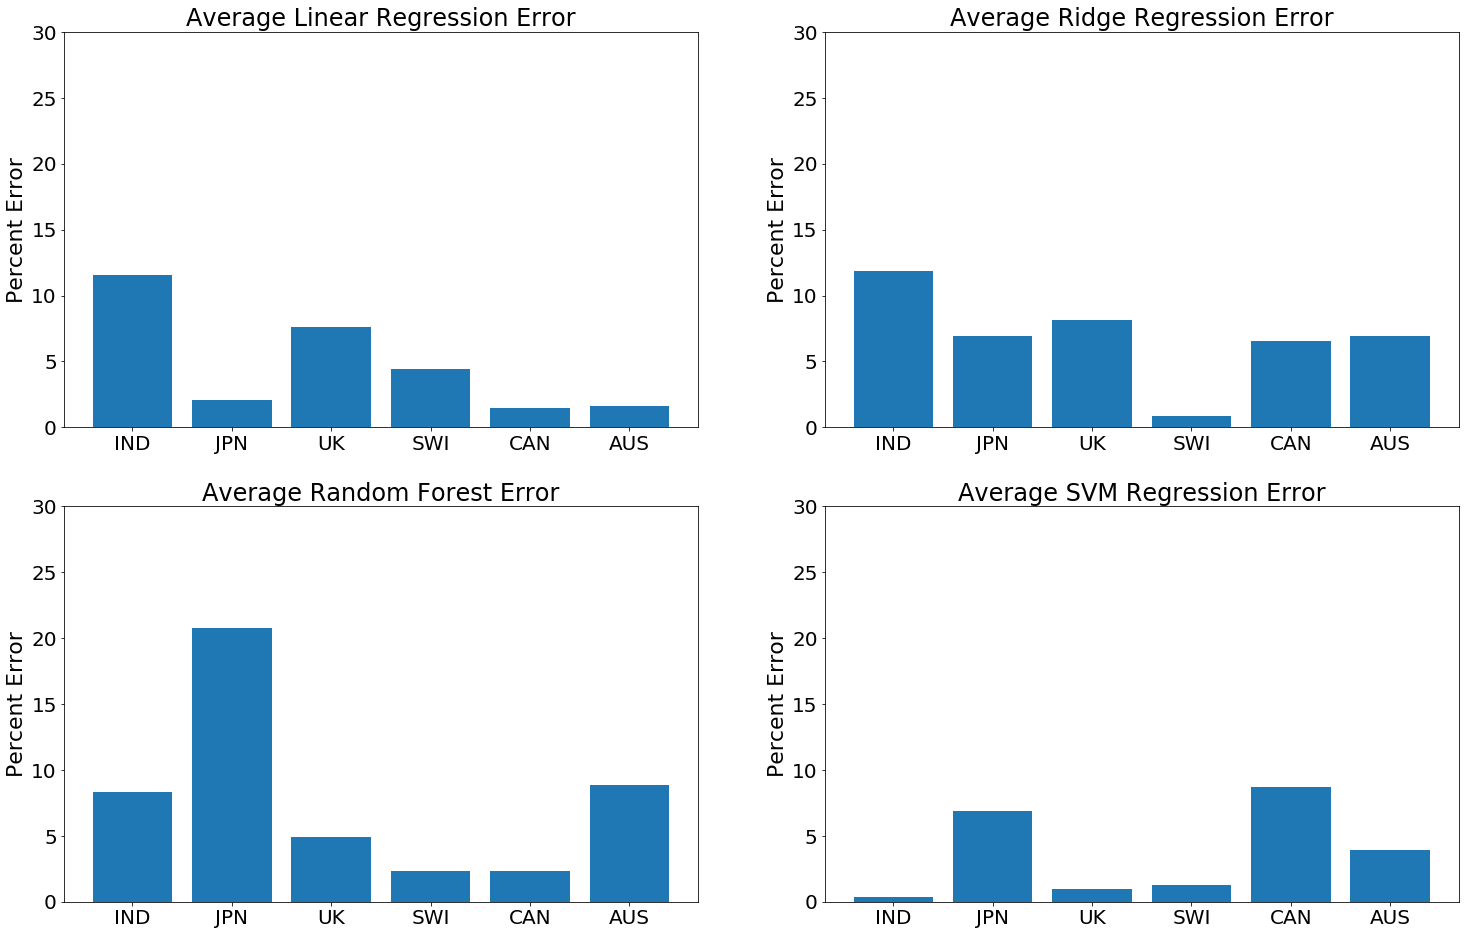

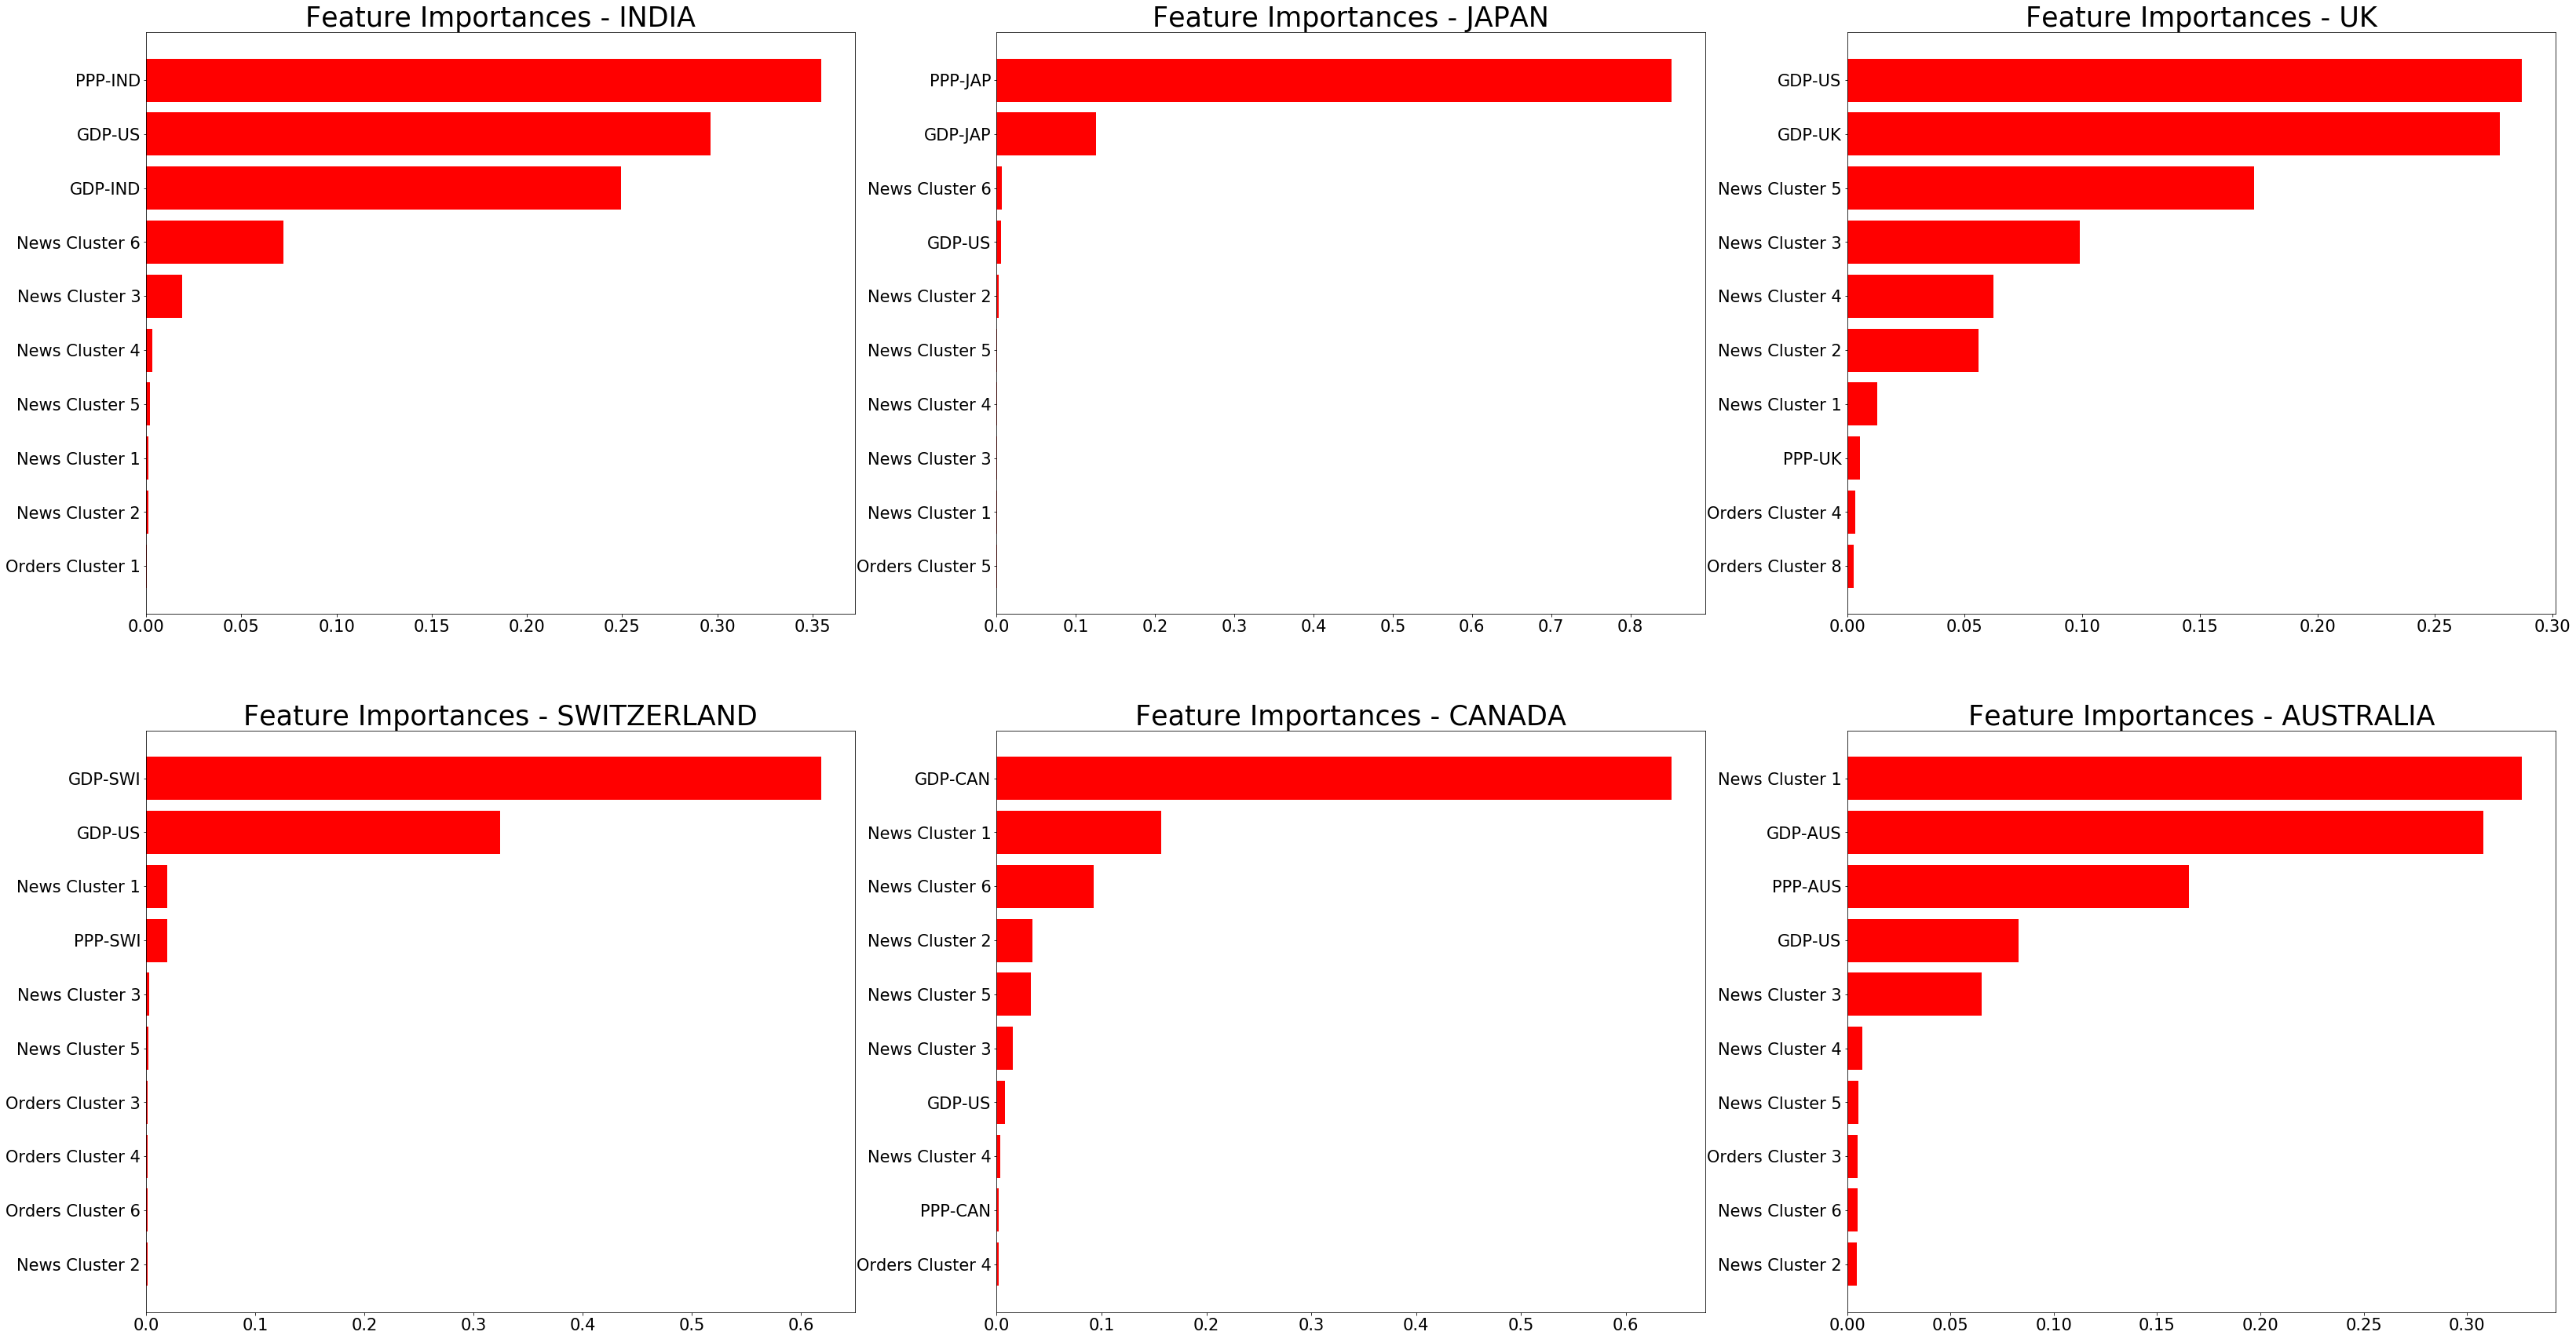

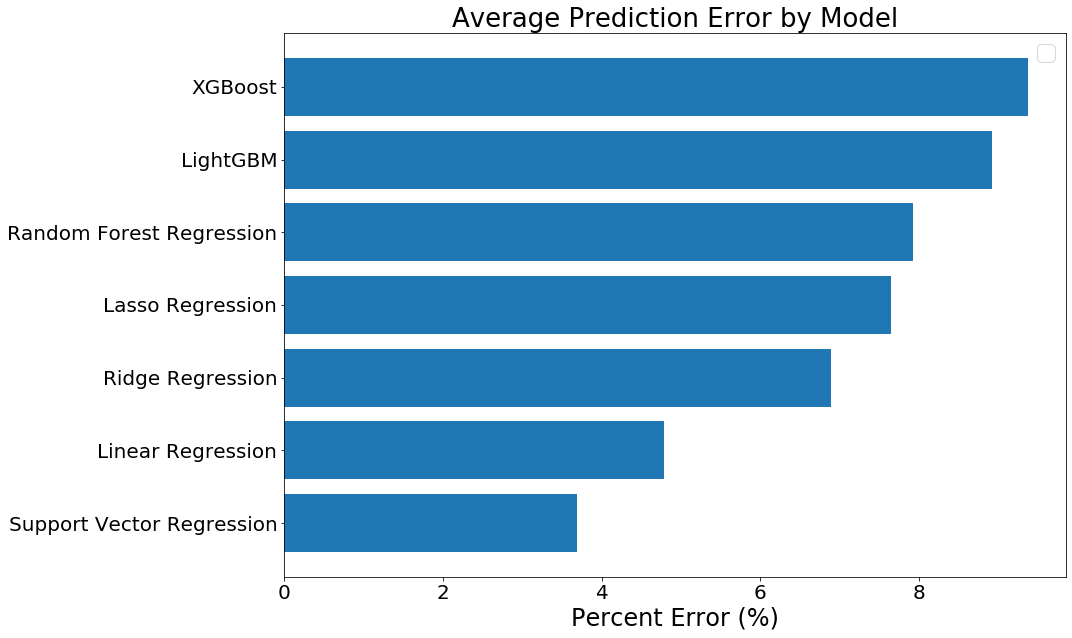

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 19 11:55:13 2020
@author: nabeelhussain
"""

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR
#import lightgbm as lgb
#import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#import data

#OECD - Inflation Rates
Infl_Rate_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/Global Indicator Data/INFL_RATE.csv', index_col=0)
FER_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/Global Indicator Data/FER.csv', index_col=0)

#OECD - PPP
PPP_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/Global Indicator Data/PPP.csv', index_col=0)

#International Monetary Fund, World Economic Outlook Database - Imports/Exports
Imports_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/Global Indicator Data/IMPORTS.csv', index_col=0)
Exports_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/Global Indicator Data/EXPORTS.csv', index_col=0)
GDP_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/Global Indicator Data/COUNTRY_GDP.csv', index_col=0)

Topic_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/documents_to_topics.csv', index_col=0)

#Must select number of topics from LDA here
num_topics = 6

#first year that the data starts
start_year = prev_date = '1981'

#initialize
year_count = 0 
topics = [0]*num_topics
topic_count_per_year = [[] for _ in range(2019-1981 + 2)]

for i in range(len(Topic_data)):
    date = Topic_data.iloc[i,3]
    if isinstance(date, str) == True:

        date = date[:4]
        if date >= prev_date:
            
            if date == prev_date:
            
                for t in range(num_topics):
                    #topics columns start at 8 from csv file
                    topics[t] += Topic_data.iloc[i,8+t]
                   
                topic_count_per_year[year_count] = topics
        
            else:
            
                print("article:",i)
                print("topic count:",topic_count_per_year[year_count])
                print("next year:",date)
                print("previous year:",prev_date)
                
                topics = [0]*num_topics
                for t in range(num_topics):
                    topics[t] += Topic_data.iloc[i,8+t]
                
                year_count += 1
        
                prev_date = date

for year in range(len(topic_count_per_year)):
    total = sum(topic_count_per_year[year])
    topic_count_per_year[year] = [x / total for x in topic_count_per_year[year]]
    print("percent topic count:",topic_count_per_year[year_count])

topic_count_per_year = [x for x in topic_count_per_year if x != []]

#Executive Orders
#We decided to use 9 clusters because that returned the  best results. Can adjust range if you want
for n in range(9,10):
    print('Order Clusters: ',n)
    Order_data = pd.read_csv('/Users/nabeelhussain/Desktop/NEU/CS5100/order_topics/orders_to_topics_'+str(n)+'.csv', index_col=0)
    Order_data = Order_data.iloc[::-1]
    prev_date = 1981
    #initialize
    year_count = 0 
    order_topics = [0]*n
    order_topic_count_per_year = [[] for _ in range(2019-1981 + 2)]
    index = Order_data.index
    
    for i in range(len(Order_data)):
        date = index[i]
        #print(date)
        if isinstance(date, np.int64) == True:
    
            if date >= prev_date:
                
                if date == prev_date:
                
                    for t in range(n):
                        #topics columns start at 3 from csv file
                        order_topics[t] += Order_data.iloc[i,3+t]
                       
                    order_topic_count_per_year[year_count] = order_topics
            
                else:
                
                    #print("article:",i)
                    #print("topic count:",topic_count_per_year[year_count])
                    #print("next year:",date)
                    #print("previous year:",prev_date)
                    
                    order_topics = [0]*n
                    for t in range(n):
                        order_topics[t] += Order_data.iloc[i,3+t]
                    
                    year_count += 1
            
                    prev_date = date

    
    #weird data point - manually fix
    GDP_data['2017'][0] = '59927.92982'
    
    #select countries to use here
    countries = ['INDIA','JAPAN','UK','SWITZERLAND','CANADA','AUSTRALIA']
    
    
    #select the number of years you want to predict the FER for here:
    num_years = 1
    #i.e. if num_years = 5, predict the FER for 2015,2016,2017,2018,2019
    end_year = 2019
    test_year = end_year - num_years
    
    #set up data structures for training/testing
    x_train,y_train,x_test,y_true = ([[] for _ in range(len(countries))] for i in range(4))
    
    #set up data structures for model/results
    lin_regr = [[] for _ in range(len(countries))]
    ridge = [[] for _ in range(len(countries))]
    RandomForest = [[] for _ in range(len(countries))]
    Lasso = [[] for _ in range(len(countries))]
    SVM = [[] for _ in range(len(countries))]
    LightGBM = [[] for _ in range(len(countries))]
    XGBoost = [[] for _ in range(len(countries))]
    
    lin_regr_predictedFER = np.zeros((num_years, len(countries)))
    ridge_predictedFER = np.zeros((num_years, len(countries)))
    RandomForest_predictedFER = np.zeros((num_years, len(countries)))
    Lasso_predictedFER = np.zeros((num_years, len(countries)))
    SVM_predictedFER = np.zeros((num_years, len(countries)))
    LighGBM_predictedFER = np.zeros((num_years, len(countries)))
    XGBoost_predictedFER = np.zeros((num_years,len(countries)))
    
    lin_regr_error_country = np.zeros((num_years, len(countries)))
    ridge_error_country = np.zeros((num_years, len(countries)))
    RandomForest_error_country = np.zeros((num_years, len(countries)))
    Lasso_error_country = np.zeros((num_years, len(countries)))
    SVM_error_country = np.zeros((num_years, len(countries)))
    LGBM_error_country = np.zeros((num_years, len(countries)))
    XGB_error_country = np.zeros((num_years,len(countries)))
    
    importances = [[] for _ in range(len(countries))]
    indices = [[] for _ in range(len(countries))]
    feature_list = [[] for _ in range(len(countries))]
    
    std_lin_regr,std_ridge,std_RandomForest,std_Lasso,std_SVM = ([[] for _ in range(len(countries))] for i in range(5))
    
    for j in range(num_years):
    
        for i in range(len(countries)):
            
            #collect training data which is data from 1981 to whatever year that you decided earlier
            #X1 = Infl_Rate_data.loc[["USA",countries[i]],str(start_year):str(test_year+j)]
            X2 = PPP_data.loc[["USA",countries[i]],str(start_year):str(test_year+j)]
            #X3 = Imports_data.loc[["USA",countries[i]],str(start_year):str(test_year+j)]
            #X4 = Exports_data.loc[["USA",countries[i]],str(start_year):str(test_year+j)]
            X5 = GDP_data.loc[["USA",countries[i]],str(start_year):str(test_year+j)]
            #X6 = Investment_data.loc[["USA",countries[i]],str(start_year):str(test_year+j)]
            
            a = (pd.concat([X2,X5])).to_numpy()
            X7 = topic_count_per_year[0:(test_year-int(start_year)+j+1)]
            X7 = ((pd.DataFrame(X7)).transpose()).to_numpy()
            
            X8 = order_topic_count_per_year[0:(test_year-int(start_year)+j+1)]
            X8 = ((pd.DataFrame(X8)).transpose()).to_numpy()
            
            x_train[i] = (np.concatenate((a, X7, X8))).transpose()
            
            #the y target data is the FER data for your range of years
            Y1 = FER_data.loc[[countries[i]],str(start_year):str(test_year+j)]
            y_train[i] = (Y1.transpose()).to_numpy()
        
            #set up regression models
            lin_regr[i] = linear_model.LinearRegression()
            ridge[i] = Ridge(alpha=1.0)
            RandomForest[i] = RandomForestRegressor( max_depth=10, random_state=0, bootstrap = False)
            Lasso[i] = linear_model.Lasso(alpha=0.1)
            SVM[i] = SVR(kernel='linear',C=0.0002, tol = 1e-3, epsilon = 0.1255)
            
            #params = { 'max_depth' : 10, 'min_data':1 , 'num_leaves' : 2000 , 'verbose':-1, 'silent':1}
            #LightGBM[i] = lgb.train(params, lgb.Dataset(x_train[i],label = y_train[i].flatten()))
            #XGBoost[i] = xgb.train(params, xgb.DMatrix(x_train[i], label = y_train[i].flatten()))
            
            #fit training data to models
            lin_regr[i].fit(x_train[i], y_train[i])
            ridge[i].fit(x_train[i], y_train[i])
            RandomForest[i].fit(x_train[i], y_train[i])
            Lasso[i].fit(x_train[i], y_train[i])
            SVM[i].fit(x_train[i], y_train[i])
    
            #set up testing data, which is the start year you defined + 1 for each iteration
            #X_1 = Infl_Rate_data.loc[["USA",countries[i]],str(test_year+j+1)]
            X_2 = PPP_data.loc[["USA",countries[i]],str(test_year+j+1)]
            #X_3 = Imports_data.loc[["USA",countries[i]],str(test_year+j+1)]
            #X_4 = Exports_data.loc[["USA",countries[i]],str(test_year+j+1)]
            X_5 = GDP_data.loc[["USA",countries[i]],str(test_year+j+1)]
            #X_6 = Investment_data.loc[["USA",countries[i]],str(test_year+j+1)]
            X_7 = topic_count_per_year[(test_year-int(start_year)+j+1)]
            
            X_8 = order_topic_count_per_year[(test_year-int(start_year)+j+1)]

            b = (pd.concat([X_2,X_5])).to_numpy()
            x_test[i] = np.concatenate((b, X_7, X_8))
        
            #predict FER values for next year
            lin_regr_predictedFER[j][i] = lin_regr[i].predict([x_test[i]])
            ridge_predictedFER[j][i] = ridge[i].predict([x_test[i]])
            RandomForest_predictedFER[j][i] = RandomForest[i].predict([x_test[i]])
            Lasso_predictedFER[j][i] = Lasso[i].predict([x_test[i]])
            SVM_predictedFER[j][i] = SVM[i].predict([x_test[i]])
            #LighGBM_predictedFER[j][i] = LightGBM[i].predict([x_test[i]])
            #XGBoost_predictedFER[j][i] = XGBoost[i].predict(xgb.DMatrix(np.array([x_test[i]])))
            
            #obtain true FER values for each country
            y_true[i] = FER_data.loc[countries[i],str(test_year+j+1)]
            
            #percent error in matrix form: (year x country) for each model
            lin_regr_error_country[j][i] = np.abs((lin_regr_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            ridge_error_country[j][i] = np.abs((ridge_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            RandomForest_error_country[j][i] = np.abs((RandomForest_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            Lasso_error_country[j][i] = np.abs((Lasso_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            SVM_error_country[j][i] = np.abs((SVM_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            #LGBM_error_country[j][i] = np.abs((LighGBM_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            #XGB_error_country[j][i] = np.abs((XGBoost_predictedFER[j][i] - y_true[i]) / y_true[i]) * 100
            
    #average recursive linear regression error by year
    avg_lin_regr_error_yearly = lin_regr_error_country.mean(axis=1)
    #average error over years
    overall_lin_regr_error = np.mean(avg_lin_regr_error_yearly)
    print("Linear Regression Error:",overall_lin_regr_error)
    
    #average recursive ridge regression error by year
    avg_ridge_error_yearly = ridge_error_country.mean(axis=1)
    #average error over years
    overall_ridge_error = np.mean(avg_ridge_error_yearly)
    print("Ridge Regression Error:",overall_ridge_error)
    
    #average recursive random forest regression error by year
    avg_RandomForest_error_yearly = RandomForest_error_country.mean(axis=1)
    #average error over years
    overall_RandomForest_error = np.mean(avg_RandomForest_error_yearly)
    print("Random Forest Regression Error:",overall_RandomForest_error)
    
    #average recursive lasso regression error by year
    avg_Lasso_error_yearly = Lasso_error_country.mean(axis=1)
    #average error over years
    overall_Lasso_error = np.mean(avg_Lasso_error_yearly)
    print("Lasso Regression Error:",overall_Lasso_error)
    
    #average recursive SVM regression error by year
    avg_SVM_error_yearly = SVM_error_country.mean(axis=1)
    #average error over years
    overall_SVM_error = np.mean(avg_SVM_error_yearly)
    print("SVM Regression Error:",overall_SVM_error)


avg_model_error = (avg_lin_regr_error_yearly+avg_ridge_error_yearly+avg_RandomForest_error_yearly+avg_SVM_error_yearly)/4

countries_short = ['IND','JAP','UK','SWI','CAN','AUS']

# Plot the feature importances of the forest
for i in range(len(countries_short)):
    importances[i] = RandomForest[i].feature_importances_
    indices = np.argsort(importances[i])[::-1]
    feature_list[i] = ['PPP-US','PPP-'+countries_short[i],
    'GDP-US','GDP-'+countries_short[i],'News Cluster 1','News Cluster 2','News Cluster 3','News Cluster 4',
    'News Cluster 5','News Cluster 6','Orders Cluster 1','Orders Cluster 2','Orders Cluster 3','Orders Cluster 4',
    'Orders Cluster 5','Orders Cluster 6','Orders Cluster 7','Orders Cluster 8','Orders Cluster 9']
    
    feature_list[i] = [feature_list[i][j] for j in indices]
    importances[i] = [importances[i][k] for k in indices]

    std_lin_regr[i] = np.std(lin_regr_error_country[:,i])
    std_ridge[i] = np.std(ridge_error_country[:,i])
    std_RandomForest[i] = np.std(RandomForest_error_country[:,i])
    std_Lasso[i] = np.std(Lasso_error_country[:,i])
    std_SVM[i] = np.std(SVM_error_country[:,i])


fig, axs = plt.subplots(2, 2, figsize = (25,16))
axs[0, 0].bar(list(range(len(countries))), (lin_regr_error_country.tolist())[0])
axs[0, 0].set_title('Average Linear Regression Error', fontsize = 24)
axs[0, 0].set_xticks(list(range(len(countries))))
axs[0, 0].set_xticklabels(('IND','JPN','UK','SWI','CAN','AUS'))
axs[0, 0].tick_params(axis = 'both', which = 'major', labelsize = 20)
axs[0, 0].set_ylim(0, 30)
axs[0, 0].set_ylabel('Percent Error', fontsize = 22)

axs[0, 1].bar(list(range(len(countries))), (ridge_error_country.tolist())[0])
axs[0, 1].set_title('Average Ridge Regression Error', fontsize = 24)
axs[0, 1].set_xticks(list(range(len(countries))))
axs[0, 1].set_xticklabels(('IND','JPN','UK','SWI','CAN','AUS'))
axs[0, 1].tick_params(axis = 'both', which = 'major', labelsize = 20)
axs[0, 1].set_ylim(0, 30)
axs[0, 1].set_ylabel('Percent Error', fontsize = 22)

axs[1, 0].bar(list(range(len(countries))), (RandomForest_error_country.tolist())[0])
axs[1, 0].set_title('Average Random Forest Error', fontsize = 24)
axs[1, 0].set_xticks(list(range(len(countries))))
axs[1, 0].set_xticklabels(('IND','JPN','UK','SWI','CAN','AUS'))
axs[1, 0].tick_params(axis = 'both', which = 'major', labelsize = 20)
axs[1, 0].set_ylim(0, 30)
axs[1, 0].set_ylabel('Percent Error', fontsize = 22)

axs[1, 1].bar(list(range(len(countries))), (SVM_error_country.tolist())[0])
axs[1, 1].set_title('Average SVM Regression Error', fontsize = 24)
axs[1, 1].set_xticks(list(range(len(countries))))
axs[1, 1].set_xticklabels(('IND','JPN','UK','SWI','CAN','AUS'))
axs[1, 1].tick_params(axis = 'both', which = 'major', labelsize = 20)
axs[1, 1].set_ylim(0, 30)
axs[1, 1].set_ylabel('Percent Error', fontsize = 22)



fig, axs = plt.subplots(2, 3, figsize = (55,30))

count = 0
for i in range(2):
    for j in range(3):
        axs[i, j].set_title("Feature Importances " + "- " + countries[count])
        axs[i, j].barh(list(range(len(importances[count][0:10]))),importances[count][0:10], color="r", align="center")
        axs[i, j].set_yticks(list(range(len(importances[0][0:10]))))
        axs[i, j].set_yticklabels(feature_list[count][0:10])
        axs[i, j].invert_yaxis()
        axs[i, j].title.set_fontsize(35)
        axs[i, j].yaxis.label.set_fontsize(21)
        axs[i, j].tick_params(axis = 'both', which = 'major', labelsize = 21)
        
        count += 1

if num_years > 1:
    fig2, axs2 = plt.subplots(2, 3, figsize = (25,16))
    count = 0
    for i in range(2):
        for j in range(3):        
            axs2[i, j].set_title("Actual vs. Predicted Foreign Exchange Rate " + "- " + countries[count])
            axs2[i, j].plot(list(range(1980,2020)), FER_data.loc[countries[count]], color='black', label = 'Actual FER')
            axs2[i, j].plot(list(range(2020-num_years,2020)), SVM_predictedFER[:,count], color='green', label = 'Predicted FER')
            axs2[i, j].set_ylabel('Exchange Rate')
            axs2[i, j].title.set_fontsize(16)
            axs2[i, j].yaxis.label.set_fontsize(15)
            axs2[i, j].tick_params(axis = 'both', which = 'major', labelsize = 15)
            axs2[i, j].legend(loc="bottom right")
    
            count += 1
    
    fig = plt.figure(figsize=(14,10))
    plt.plot(list(range(1980,2020)), FER_data.loc[countries[0]], color='black', label = 'Actual FER')
    plt.plot(list(range(2020-num_years,2020)), SVM_predictedFER[:,0], color='green', label = 'Predicted FER')
    plt.ylabel('Exchange Rate', fontsize = 24)
    plt.xticks(list(range(1980,2020)), rotation='vertical', fontsize = 20)
    plt.yticks(fontsize=20)
    plt.title("Actual vs. Predicted Foreign Exchange Rate " + "- " + countries[0], fontsize = 26)
    plt.legend(loc="bottom right", fontsize = 22)
    plt.show()

    #line plot
    plt.plot(list(range(test_year+1,end_year+1)), avg_model_error, color='black')
    plt.xlabel('Target Year')
    plt.ylabel('Percent Error')
    plt.title('Average Model Prediction Error by Year')
    plt.show()

#Avg model error
models = ['Support Vector Regression','Linear Regression','Ridge Regression','Lasso Regression','Random Forest Regression','LightGBM','XGBoost']
fig = plt.figure(figsize=(14,10))
plt.barh(models, [overall_SVM_error,overall_lin_regr_error,overall_ridge_error,overall_Lasso_error,overall_RandomForest_error, 8.92, 9.38])
plt.xlabel('Percent Error (%)', fontsize = 24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title("Average Prediction Error by Model", fontsize = 26)
plt.legend(loc="bottom right", fontsize = 22)
plt.show()
